In [29]:
import vision_agent as va
import pandas as pd
import textwrap
import json
import os
from IPython.display import Image
from PIL import Image

Get the LMM model

In [2]:
model = va.lmm.get_lmm("llava")

## Analyze an image of document

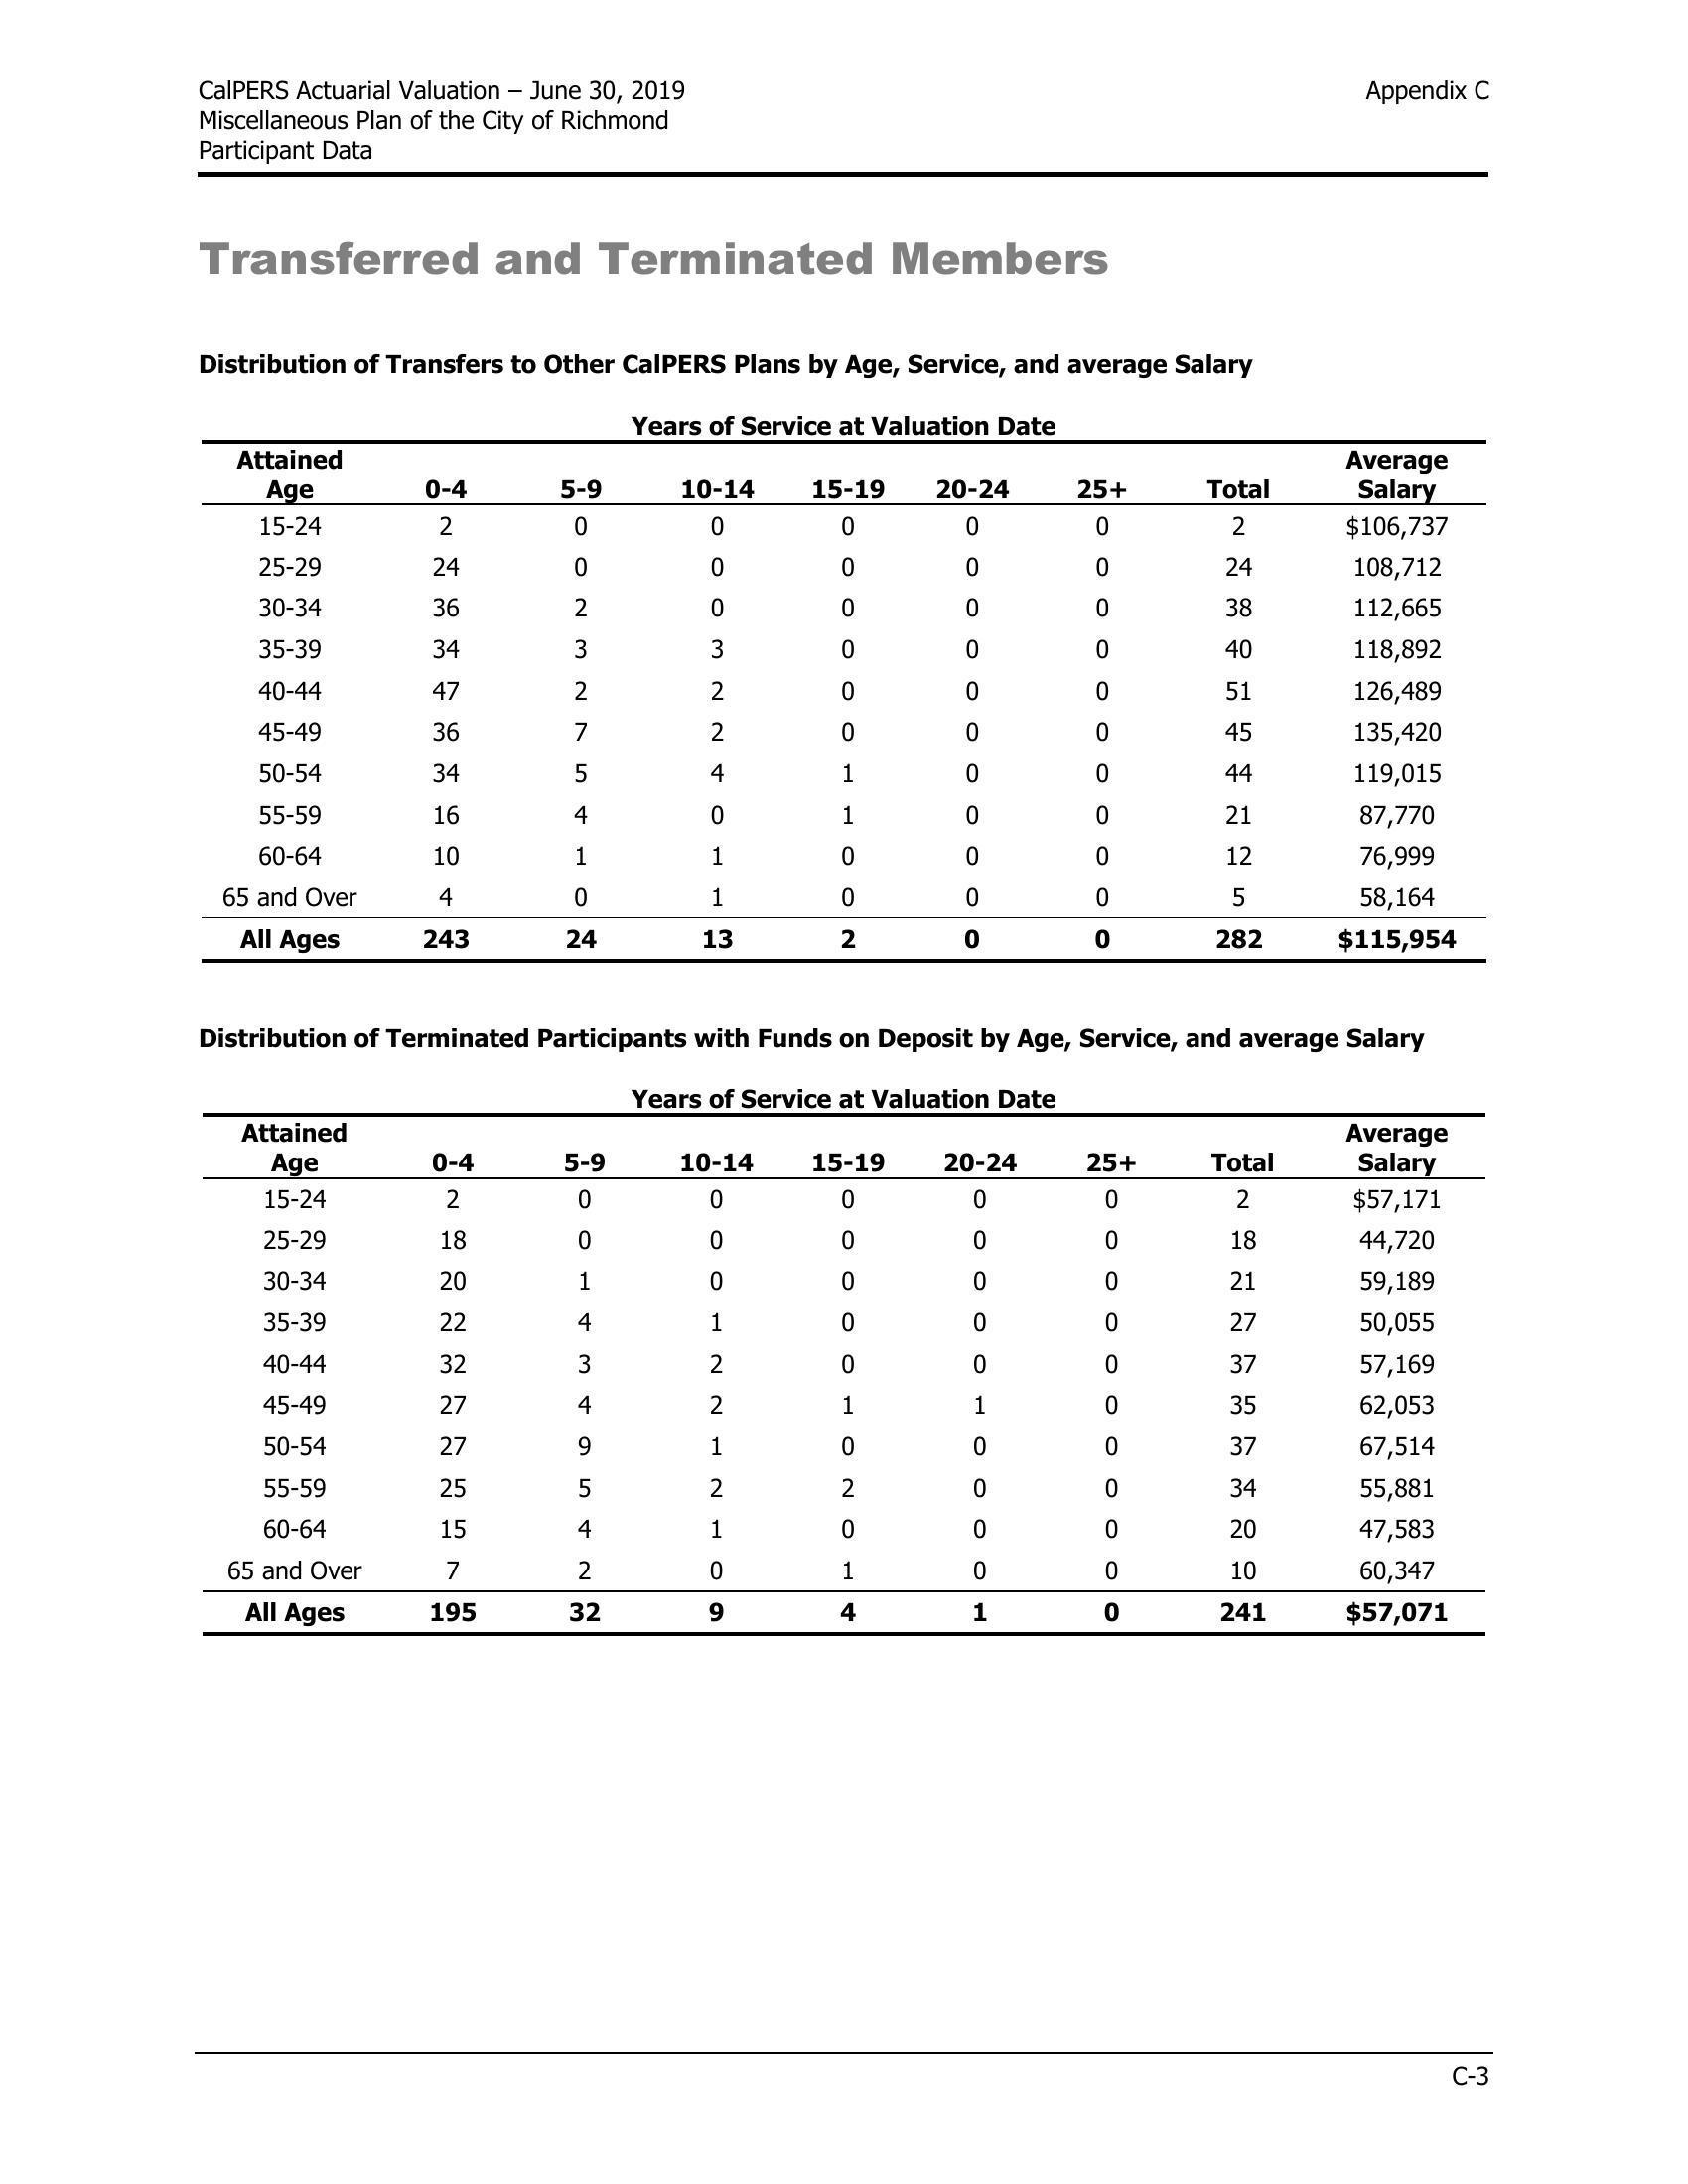

In [3]:
Image(filename="img/doc3.jpg")

Generate a response based on sample query and image.

In [13]:
image_path = "img/doc3.jpg"
prompt = "Here is the image of a page from a document. Parse this document, if you can find a table and its columns in the page, print Table Title in json format and if not found Table title will be 'N/A'"
# The llava model can take two additional parameters
# temperature (float): The temperature parameter for text generation. Higher values (e.g., 1.0) make the output more random, while lower values (e.g., 0.1) make it more deterministic. Default is 0.2.
# max_new_tokens (int): The maximum number of tokens to generate. Default is 1500.
resp = model.generate(prompt, image_path, temperature=0.1, max_new_tokens=1500)
print(textwrap.fill(resp, 80))

```json {   "table_title": "TRANSFERRED AND TERMINATED MEMBERS" } ```


Write a post-processing function to parse the output and get the desired result. Here its a simple one where it looks for N/A and json like output and acts accordingly. 
You can replace these with any python operations like regex, string manipulations etc

In [8]:
def get_table_title(resp):
    if "N/A" in resp:
        title = None
    else:
        try:
            title = json.loads(resp[resp.find("{"):resp.find("}")+1])
        except:
            title = None
    return title['table_title'] if title else "N/A"

In [14]:
df_doc = pd.DataFrame({"image_paths": ["img/doc1.jpg", "img/doc2.jpg", "img/doc3.jpg"]})
ds = va.data.DataStore(df_doc)
ds = ds.add_lmm(model)
ds = ds.add_column(name="table_title", prompt=prompt, func=get_table_title)
ds.df

100%|██████████| 3/3 [00:19<00:00,  6.49s/it]


,image_paths,image_id,table_title
0,img/doc1.jpg,75499b5e-ffeb-4736-8492-fca4baa37987,N/A
1,img/doc2.jpg,1a8a24c1-caf1-4c69-876c-0d63712b3f7a,N/A
2,img/doc3.jpg,b7b78c26-8584-492d-8bb7-35ce91e83c77,TRANSFERRED AND TERMINATED MEMBERS


## Analyze CT scan images

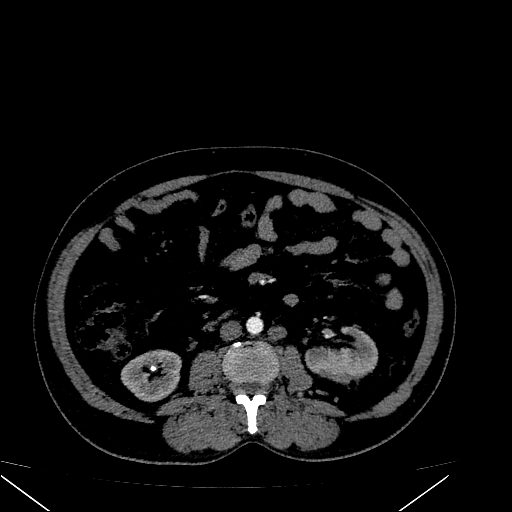

In [5]:
Image(filename="img/ct_scan1.jpg")

Here the goal is to get the LMM to look at a CT scan image and get it to respond whether it has any abnormalities

In [4]:
image_path = "img/ct_scan1.jpg"
ct_prompt = "Here is the image of kidney CT scan, Based on the CT image, Describe if the image has features that corresponds to 'Cyst' or 'Stone' or 'Tumor'. If there are no abnormalities respond its 'Normal'"
resp = model.generate(ct_prompt, image_path)
print(textwrap.fill(resp, 80))

The image you've provided appears to be a cross-sectional view of a kidney,
likely from a CT scan. Based on the image, there are several features that could
be indicative of certain conditions:  1. Cyst: There are multiple round, well-
defined structures that could be cysts. These are typically seen as round,
fluid-filled spaces within the kidney.  2. Stone: There is a small, dense, round
structure that could be a kidney stone. Kidney stones are usually seen as bright
white, round, or irregularly shaped objects within the kidney.  3. Tumor: There
is a large, irregular mass in the center of the kidney that could be a tumor.
Tumors can vary in appearance, but they are often irregularly shaped and may
have a different density compared to the surrounding tissue.  4. Normal: The
rest of the kidney appears to be of normal density and texture, without any
obvious signs of infection or inflammation.  It's important to note that a
definitive diagnosis would require a medical professional to rev

Create a datastore and add the lmm model 

In [6]:
df_ct = pd.DataFrame({"image_paths": ["img/ct_scan1.jpg", "img/ct_scan2.jpg"]})
ds_ct = va.data.DataStore(df_ct)
ds_ct = ds_ct.add_lmm(model)

Prompt the model to perform analysis on the image

In [8]:
ds_ct = ds_ct.add_column("analysis", ct_prompt)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:31<00:00, 15.76s/it]


Add embedder to the data store

In [ ]:
ds_ct = ds_ct.add_embedder(va.emb.get_embedder("sentence-transformer"))

Perform RAG to get the most relevant information from the generated text, some examples below

In [ ]:
ds_ct = ds_ct.build_index("analysis")
ds_ct.search("Presence of a Cyst", top_k=1)

In [ ]:
ds_ct = ds_ct.build_index("analysis")
ds_ct.search("Presence of a Tumor", top_k=1)

## Tool usage

In [2]:
t = va.tools.GroundingDINO()

In [28]:
ans = t(prompt="shoes", image="shoes.jpg", box_threshold=0.30, iou_threshold=0.2)
len(ans["labels"])

14

In [8]:
ans.keys()

dict_keys(['labels', 'scores', 'bboxes', 'size'])

In [9]:
ans["scores"]

[0.41,
 0.36,
 0.36,
 0.36,
 0.35,
 0.34,
 0.34,
 0.32,
 0.32,
 0.32,
 0.32,
 0.31,
 0.31,
 0.3]

In [20]:
t1 = va.tools.GroundingSAM()

In [24]:
ans = t1(prompt="bird", image="birds.jpg", box_threshold=0.40, iou_threshold=0.2)

In [25]:
ans["bboxes"]

[[0.05, 0.03, 0.22, 0.33],
 [0.71, 0.38, 0.94, 0.95],
 [0.45, 0.26, 0.6, 0.56],
 [0.2, 0.21, 0.37, 0.63]]

In [18]:
ans.keys()

dict_keys(['labels', 'bboxes', 'masks', 'scores'])

In [24]:
img = Image.fromarray(ans["masks"][2] * 255)

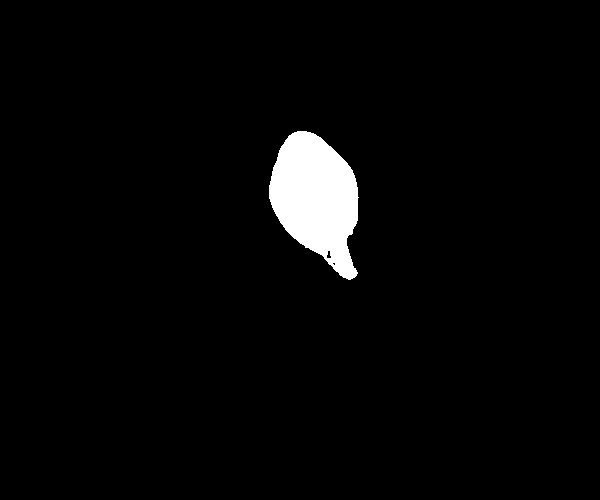

In [25]:
display(img)

In [27]:
t1(prompt="bird", image="shoes.jpg",)

{'labels': [], 'bboxes': [], 'masks': [], 'scores': []}

In [16]:
t2 = va.tools.CLIP()

In [26]:
t2(prompt="crow, cheetah", image="birds.jpg",)

{'labels': ['crow', ' cheetah'], 'scores': [0.9999, 0.0001]}